Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Loss: 117.06
Epoch 2, Loss: 100.50
Epoch 3, Loss: 96.88
Epoch 4, Loss: 94.53
Epoch 5, Loss: 93.09
Epoch 6, Loss: 92.05
Epoch 7, Loss: 91.26
Epoch 8, Loss: 90.61
Epoch 9, Loss: 90.07
Epoch 10, Loss: 89.60


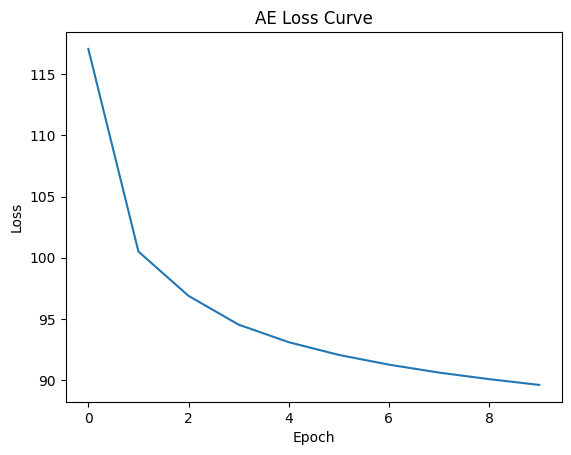

In [ ]:
#AE
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

# Data loading
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
losses = []
for epoch in range(10):
    epoch_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        output = model(images)
        loss = criterion(output, images.view(-1, 28*28))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.2f}")

torch.save(model.state_dict(), "ae_model.pth")

# Save loss curve
plt.plot(losses)
plt.title("AE Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.close()


Epoch 1, VAE Loss: 12487529.24
Epoch 2, VAE Loss: 10532799.11
Epoch 3, VAE Loss: 10128482.94
Epoch 4, VAE Loss: 9955237.98
Epoch 5, VAE Loss: 9861948.75
Epoch 6, VAE Loss: 9790433.24
Epoch 7, VAE Loss: 9730054.10
Epoch 8, VAE Loss: 9669343.39
Epoch 9, VAE Loss: 9617852.46
Epoch 10, VAE Loss: 9571872.65


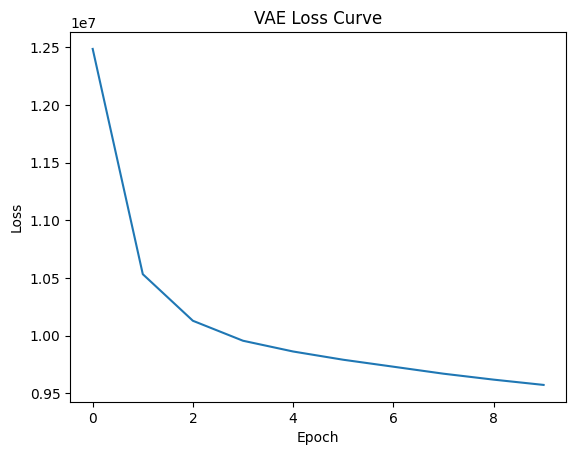

In [ ]:
#VAE
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder_fc = nn.Linear(784, 128)
        self.mu = nn.Linear(128, 2)
        self.logvar = nn.Linear(128, 2)
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, 784)
        h = torch.relu(self.encoder_fc(x))
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Data loading
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
vae_losses = []
for epoch in range(10):
    epoch_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        recon_batch, mu, logvar = vae(images)
        loss = loss_function(recon_batch, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    vae_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, VAE Loss: {epoch_loss:.2f}")

torch.save(vae.state_dict(), "vae_model.pth")

# Save loss curve
plt.plot(vae_losses)
plt.title("VAE Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.close()


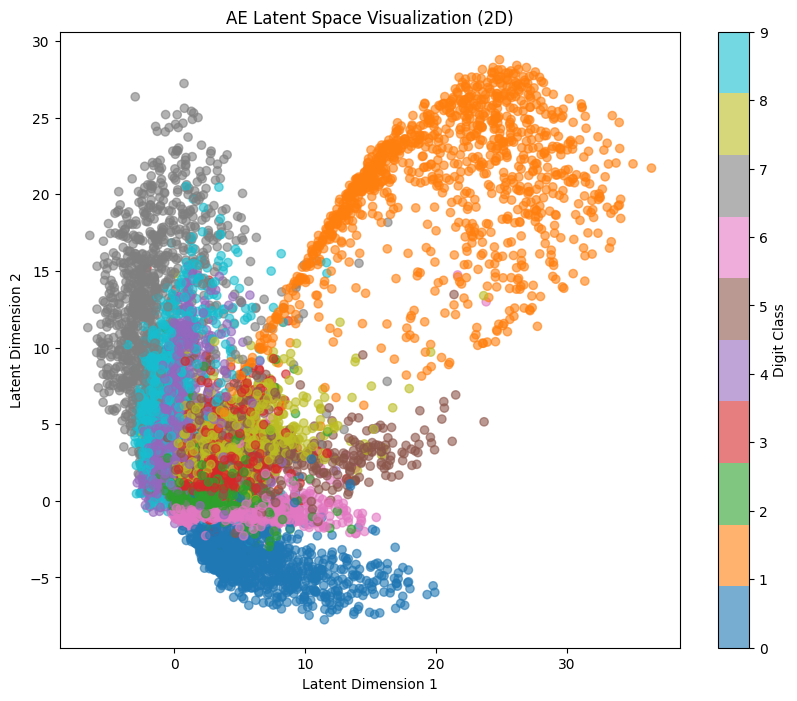

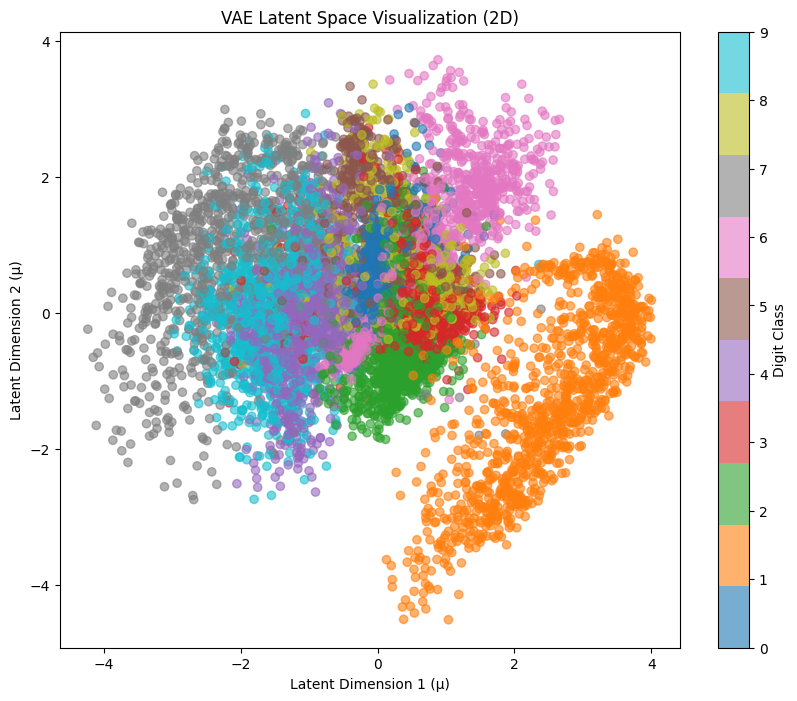

In [ ]:


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def get_ae_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            z = model.encoder(images)
            latent_representations.append(z.cpu().numpy())
            labels.append(lbls.cpu().numpy())
    return np.concatenate(latent_representations), np.concatenate(labels)

def get_vae_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            _, mu, _ = model(images)
            latent_representations.append(mu.cpu().numpy())
            labels.append(lbls.cpu().numpy())
    return np.concatenate(latent_representations), np.concatenate(labels)


ae_latent_coords, ae_labels = get_ae_latent_representations(model, test_loader, device)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(ae_latent_coords[:, 0], ae_latent_coords[:, 1], c=ae_labels, cmap='tab10', alpha=0.6)
plt.title('AE Latent Space Visualization (2D)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(scatter, label='Digit Class')
plt.show()



vae_latent_coords, vae_labels = get_vae_latent_representations(vae, test_loader, device)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(vae_latent_coords[:, 0], vae_latent_coords[:, 1], c=vae_labels, cmap='tab10', alpha=0.6)
plt.title('VAE Latent Space Visualization (2D)')
plt.xlabel('Latent Dimension 1 (μ)')
plt.ylabel('Latent Dimension 2 (μ)')
plt.colorbar(scatter, label='Digit Class')
plt.show()


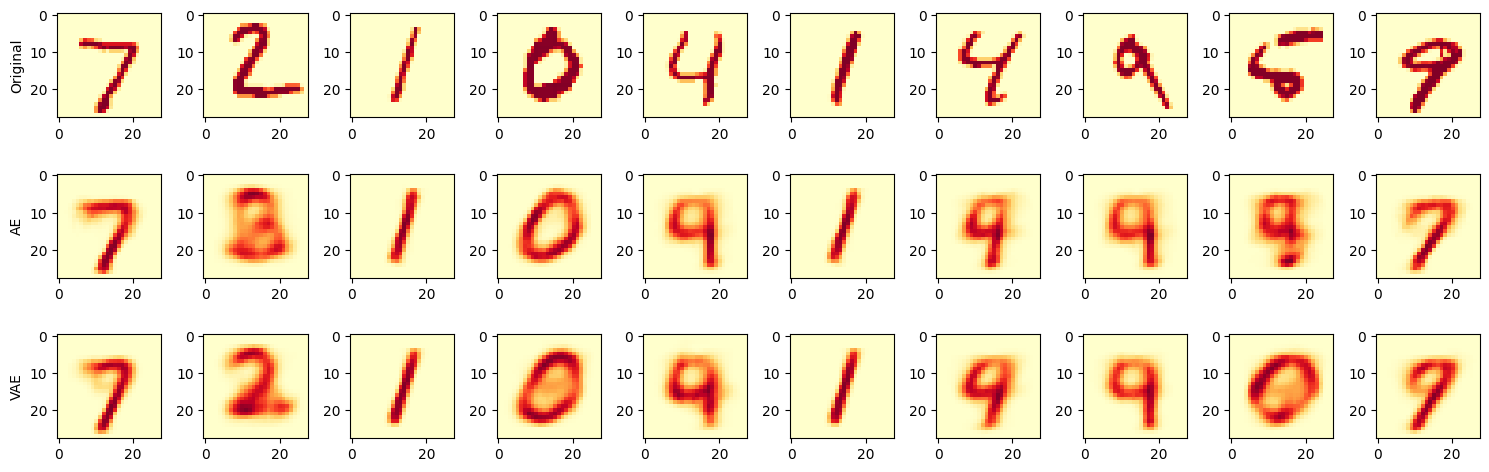

In [ ]:
#Reconstructions
model.eval()
vae.eval()

ae_recon = []
vae_recon = []
original = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        original = images[:10].cpu().numpy()
        ae_recon = model(images[:10]).cpu().numpy()
        vae_out, _, _ = vae(images[:10])
        vae_recon = vae_out.cpu().numpy()
        break

fig, axs = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    axs[0, i].imshow(original[i][0], cmap='YlOrRd')
    axs[1, i].imshow(ae_recon[i].reshape(28, 28), cmap='YlOrRd')
    axs[2, i].imshow(vae_recon[i].reshape(28, 28), cmap='YlOrRd')
axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("AE")
axs[2, 0].set_ylabel("VAE")
plt.tight_layout()
plt.show()
plt.close()


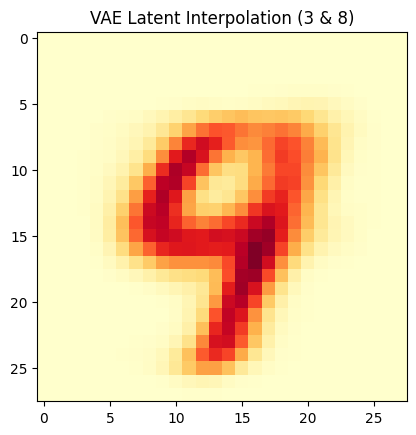

In [ ]:

vae.eval()
img3 = test_data[0][0].unsqueeze(0).to(device)
img8 = test_data[1][0].unsqueeze(0).to(device)

with torch.no_grad():
    h3 = torch.relu(vae.encoder_fc(img3.view(-1, 784)))
    mu3 = vae.mu(h3)

    h8 = torch.relu(vae.encoder_fc(img8.view(-1, 784)))
    mu8 = vae.mu(h8)


    z_interp_vae = 0.5 * mu3 + 0.5 * mu8
    gen_img_vae = vae.decoder(z_interp_vae).view(28, 28).cpu().numpy()

plt.imshow(gen_img_vae, cmap='YlOrRd')
plt.title("VAE Latent Interpolation (3 & 8)")
plt.show()


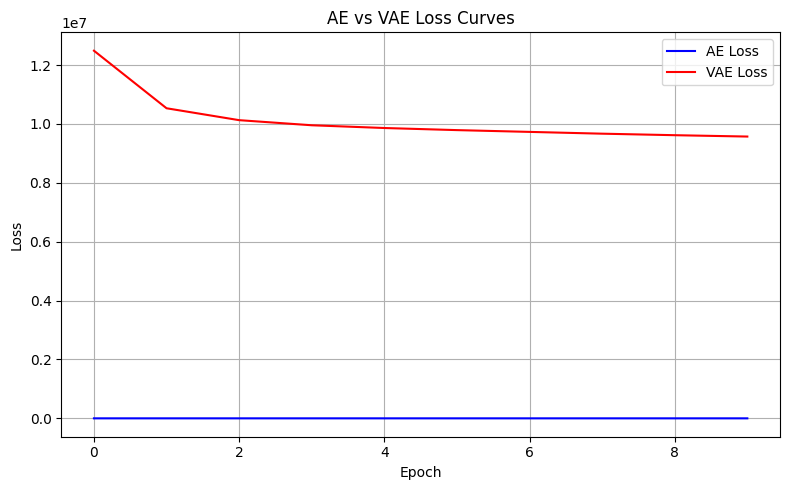

In [ ]:
# Plot AE and VAE losses in a single graph
plt.figure(figsize=(8, 5))
plt.plot(losses, label='AE Loss', color='blue')
plt.plot(vae_losses, label='VAE Loss', color='red')
plt.title("AE vs VAE Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


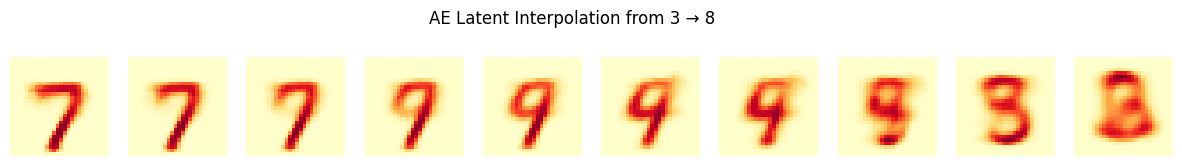

In [ ]:
# Multi-step interpolation between digits 3 and 8 using AE
model.eval()
img3 = test_data[0][0].unsqueeze(0).to(device)  # Digit 3
img8 = test_data[1][0].unsqueeze(0).to(device)  # Digit 8

with torch.no_grad():
    z1 = model.encoder(img3)
    z2 = model.encoder(img8)

    steps = 10
    fig, axs = plt.subplots(1, steps, figsize=(15, 2))
    for i, alpha in enumerate(torch.linspace(0, 1, steps)):
        z_interp = (1 - alpha) * z1 + alpha * z2
        gen_img = model.decoder(z_interp).view(28, 28).cpu().numpy()
        axs[i].imshow(gen_img, cmap='YlOrRd')
        axs[i].axis('off')
plt.suptitle("AE Latent Interpolation from 3 → 8")
plt.show()
